# Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from sys import stdout
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from arch.unitroot import PhillipsPerron as pp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.simplefilter('ignore')
%matplotlib inline
sns.set_style("whitegrid")
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)

# 1. Importando base de dados formatada

## 1.1 Tratando os dados internos

In [2]:
# conversor de data
dt_parse = lambda dates: dt.strptime(dates, '%Y-%m-%d %H:%M:%S')
# importação de csv com os dados e indexação deles pela data
data = pd.read_csv('data/transformed/2000_2021_Brazilian_North_Region_hourly_MWmed_hydroelectric_power_series.csv',
                   header=0, names=['index','value', 'date'], parse_dates=True, index_col='index', date_parser=dt_parse)
# definição dos tipos de dados
data['value'] = data['value'].astype(float)
data['date'] = data['date'].astype('datetime64')
data = data[data['value'] > 0.0]
data.head()

,value,date
index,,
2000-01-01 00:00:00,2422.5,2000-01-01 00:00:00
2000-01-01 01:00:00,2769.3,2000-01-01 01:00:00
2000-01-01 02:00:00,3124.7,2000-01-01 02:00:00
2000-01-01 03:00:00,3154.6,2000-01-01 03:00:00
2000-01-01 04:00:00,3121.8,2000-01-01 04:00:00


# 2. ARIMA

## 2.1 Tratando os dados internos

In [3]:
split_date = '1/1/2021 12:00:00 AM'
test  = data[split_date : ]
train = data['1/7/2020 12:00:00 PM' : split_date]

train = train['value']
test = test['value']
series = pd.concat([train, test], axis=0)

series

index
2020-01-07 12:00:00    7695.265
2020-01-07 13:00:00    7914.435
2020-01-07 14:00:00    8091.972
2020-01-07 15:00:00    7525.924
2020-01-07 16:00:00    7699.582
                         ...   
2021-01-30 20:00:00    7217.682
2021-01-30 21:00:00    7187.145
2021-01-30 22:00:00    6658.727
2021-01-30 23:00:00    6529.498
2021-01-31 00:00:00    6279.152
Name: value, Length: 9350, dtype: float64

## 2.2 Métodos para treinamento

In [4]:
# Mostrar previsão de acordo com os dados originais
def plot_forecasts(series, forecasts, test):
	plt.plot(series) # blue

	# Colocando no gráfico as previsões com a cor vermelha
	for i in range(len(forecasts)):
        # Inicio e fim dos dos deslocamentos por x
		off_s = len(series) - len(test) + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]

        # Valores dos multiplos passos de previsão
		yaxis = [series[off_s]] + forecasts[i]
		plt.plot(xaxis, yaxis, color='red')

	# Gráfico
	plt.show()

# Salvar predições, excedentes e erros
def save_results_file(test, forecasts, n_steps):
	predictions = {}
	expected = {}
	erros = {}
	for i in range(n_steps):
		# Pegando os valores de multiplos passos de previsão
		ypred_ts = [forecast[i] for forecast in forecasts]
		# Salvando previsão
		predictions['t+' + str(i+1)] = ypred_ts
		ytrue_ts = test[i:len(ypred_ts)+i]
		ytrue_ts_lst = [i for i in ytrue_ts]

		# Salvando excedente
		expected['t+' + str(i+1)] = ytrue_ts_lst

		# Calculando e salvando erro
		erro = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
		erros['t+' + str(i+1)] = erro

	with open('data/retrain/hour_hydro_predictions_arima.txt', 'w') as output:
		for k, v in predictions.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')

	with open('data/retrain/hour_hydro_expected_arima.txt', 'w') as output:
		for k, v in expected.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')

	with open('data/retrain/hour_hydro_errors_arima.txt', 'w') as output:
		for k, v in erros.items():
			output.write(str(k)+'\n')
			output.write(str(v)+'\n')

# Avaliação de erro do ARIMA
def evaluate_forecasts(test, forecasts, n_steps):
    sum_rmse = 0
    sum_mape = 0
    for i in range(n_steps):
        ypred_ts = [forecast[i] for forecast in forecasts]
        ytrue_ts = test[i:len(ypred_ts)+i]
        # Calculando os erros
        mape = mean_absolute_percentage_error(ytrue_ts, ypred_ts)*100
        rmse = sqrt(mean_squared_error(ytrue_ts, ypred_ts))
        sum_rmse += rmse
        sum_mape += mape
        print(f"t+{(i+1)} RMSE: {rmse} | MAPE: {mape}")

    # média dos erros
    print(f"Média do RMSE: {sum_rmse/n_steps}")
    print(f"Média do MAPE: {sum_mape/n_steps}")

# Treinamento de previsão por ARIMA por multiplos passos
def arima_forecast(train, config, n_steps):
	p, d, q = config
	# Definindo e moldando o modelo
	model = ARIMA(train, order=(p,d,q), trend=None, trend_offset=1)
	model_fit = model.fit()

	# Fazendo previsão com multiplos passos
	yhat = model_fit.predict(len(train), len(train)+n_steps-1)
	yhat_list = [value for value in yhat]

	return yhat_list

## 2.3 Treinamento e resultado

t=(697 de 698) -> Predito=5232.071979, Esperado=5425.253000Ultimos 10 valores:
Predito=[9162.663681201759, 9140.63527008183, 9134.14477575562, 9132.232403757058, 9131.668938714633, 9131.50291826763, 9131.454001676986, 9131.439588796624, 9131.435342157241, 9131.43409091907, 9131.433722251799, 9131.43361362695, 9131.433581621512, 9131.433572191367, 9131.43356941285, 9131.433568594182, 9131.433568352968, 9131.433568281896, 9131.433568260956, 9131.433568254786, 9131.433568252969, 9131.433568252434, 9131.433568252276, 9131.433568252229], Esperado=8566.823
Predito=[8226.731475806202, 8126.697901588333, 8097.2743045300895, 8088.619729597474, 8086.074097018426, 8085.32533173787, 8085.105092002576, 8085.040311299916, 8085.021256884364, 8085.015652271616, 8085.014003746423, 8085.0135188538125, 8085.01337622885, 8085.01333427754, 8085.013321938099, 8085.01331830861, 8085.013317241042, 8085.013316927031, 8085.013316834668, 8085.013316807501, 8085.01331679951, 8085.01331679716, 8085.013316796469, 8

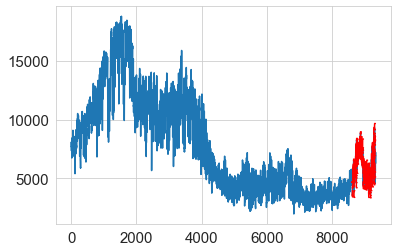

In [5]:
test = test.values
series = series.values
train = [x for x in train]

n_steps = 24

# configurações da previsão ARIMA
p_param = 1
d_param = 1
q_param = 1  # 1, 0
config = [p_param, d_param, q_param]

# lista para armazenar os paços de predição e a quantidade de predições a frente
forecasts = list()
forecasts_exp = list()
n_forecasts = len(test) - n_steps + 1

for i in range(n_forecasts):
    yhat = arima_forecast(train, config, n_steps)
    # adicionando valor de predição a lista
    forecasts.append(yhat)
    # Adicionando valor de previsão pelo treino para o proximo loop
    obs = test[i]
    train.append(obs)
    forecasts_exp.append([yhat, obs])
    stdout.write("\rt=(%i de %i) -> Predito=%f, Esperado=%f" % (i, n_forecasts, yhat[0], obs))

print("Ultimos 10 valores:")
for item in forecasts_exp[-10:]:
    print(f"Predito={item[0]}, Esperado={item[1]}")

# Salvar predições, excedentes e erros
save_results_file(test, forecasts, n_steps)
# Avaliação da previsão
evaluate_forecasts(test, forecasts, n_steps)
# Mostrar previsão
plot_forecasts(series, forecasts, test)